In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import torch
import os
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as torch_datasets

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA

from models import LAVAE, torch_dataloader, torch_latent_dataloader
import utils as ut
import train_utils as tu
import scipy

# Autoreload
%load_ext autoreload
%autoreload 2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results_folder = os.path.join('Results', 'Test')
checkpoints_folder = os.path.join(results_folder, 'Checkpoints')
plots_folder = os.path.join(results_folder, 'Plots')
print(results_folder)
if not os.path.exists(results_folder): 
    os.makedirs(results_folder)
    os.makedirs(checkpoints_folder)
    os.makedirs(plots_folder)

/var/folders/n7/b5dt_rrd5dv7z7wz4pl21bzc0000gn/T/ipykernel_38878/2974507056.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Results/Test


In [103]:
train_loader, test_loader = ut.MNIST_data(class_filter=2,augs=['flip_lr', 'flip_ud'],combine=False,targets=True)
model = torch.load(os.path.join(checkpoints_folder, 'Decs_2_100.pt'),map_location=device)

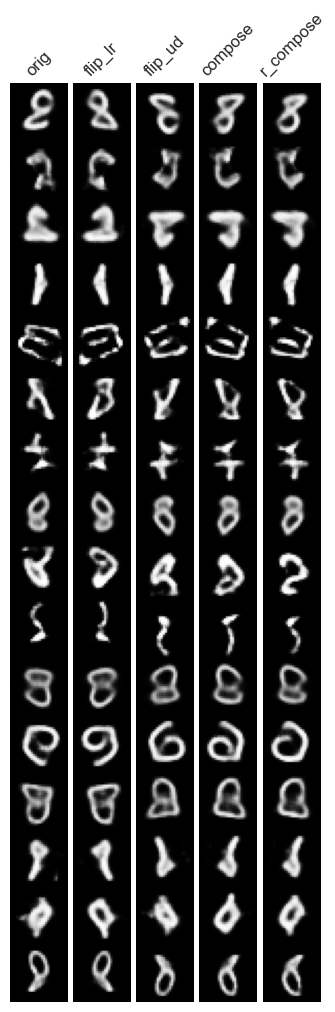

In [74]:
# Function to interpolate between two latent vectors


    z1 = z1.to(device)
    z2 = z2.to(device)
    z = torch.zeros(n_steps, z1.shape[1]).to(device)
    for i in range(n_steps):
        z[i] = z1 + (z2 - z1) * i / (n_steps - 1)
    return z


In [101]:

def interpolate(model, test_loader, device, augs, decoder=0, n_steps=10):

    # two random indices
    n_steps = 4
    idx1 = np.random.randint(0, 64)
    idx2 = np.random.randint(0, 64)
    x = next(iter(test_loader))['orig'][[idx1,idx2]].to(device)

    # get latent vectors
    z = model.encoder(x)[0]

    z_inter = torch.zeros(n_steps, z[0].shape[0]).to(device)
    for i in range(n_steps):
        z_inter[i] = z[1] + (z[1] - z[0]) * i / (n_steps - 1)

    x_sampled = {}
    x_sampled['orig'] = model.decoders[decoder](z_inter).cpu().detach().numpy()
    x_sampled[augs[0]] = model.decoders[decoder](z_inter @ model.Laugs[0]).cpu().detach().numpy()
    x_sampled[augs[1]] = model.decoders[decoder](z_inter @ model.Laugs[1]).cpu().detach().numpy()
    x_sampled['compose'] = model.decoders[decoder](z_inter @ model.Laugs[0] @ model.Laugs[1]).cpu().detach().numpy()
    x_sampled['r_compose'] = model.decoders[decoder](z_inter @ model.Laugs[1] @ model.Laugs[0]).cpu().detach().numpy()

    fig, ax = plt.subplots(1, 5, figsize=(4,12))
    for i, (k, v) in enumerate(x_sampled.items()):
        ax[i].imshow(v.reshape(-1, 28), cmap='gray')
        ax[i].set_title(k,rotation=45)
        ax[i].axis('off')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)





In [105]:
next(iter(test_loader))['orig']

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [102]:
z_inter

tensor([[-1.6222, -1.7339,  1.3488,  0.3324, -1.1838, -0.8998, -1.0939, -0.3280,
          0.7359,  0.5827,  1.7355,  1.0837, -0.6219, -1.8745,  0.4866, -0.7246],
        [-2.2286, -2.5005,  1.7785,  1.0629, -2.6948, -1.0345, -0.7468, -0.5449,
          1.2721,  1.3511,  2.7400,  1.2330, -0.7839, -2.3300,  0.3054, -1.1573],
        [-2.8350, -3.2672,  2.2082,  1.7933, -4.2057, -1.1692, -0.3996, -0.7618,
          1.8083,  2.1195,  3.7444,  1.3824, -0.9459, -2.7856,  0.1242, -1.5900],
        [-3.4414, -4.0338,  2.6378,  2.5238, -5.7166, -1.3040, -0.0525, -0.9787,
          2.3445,  2.8879,  4.7489,  1.5318, -1.1079, -3.2412, -0.0570, -2.0227]],
       grad_fn=<CopySlices>)

In [98]:
z

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [91]:
z.shape

torch.Size([2, 16])

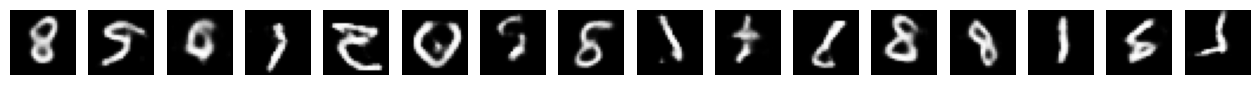

In [58]:
# plot sampled images
fig, ax = plt.subplots(1, num_samples, figsize=(num_samples, 1))
for i in range(num_samples):
    ax[i].imshow(x_sampled[i,0], cmap='gray')
    ax[i].axis('off')

# Make Video

In [ ]:
results_folder = os.path.join('Results', 'Test')
checkpoints_folder = os.path.join(results_folder, 'Checkpoints')
plots_folder = os.path.join(results_folder, 'Plots')
print(results_folder)
if not os.path.exists(results_folder): 
    os.makedirs(results_folder)
    os.makedirs(checkpoints_folder)
    os.makedirs(plots_folder)

train_loader, test_loader = ut.MNIST_data(class_filter=2,augs=['flip_lr', 'flip_ud'],combine=False,targets=True)
model = torch.load(os.path.join(checkpoints_folder, 'Decs_2_100.pt'),map_location=device)
ut.make_2D_video(model, test_loader, device, ['flip_lr', 'flip_ud'], 0,save_path=os.path.join(plots_folder,'Video/'))